<a href="https://colab.research.google.com/github/aayushkhemka89/TwitterDepressionDetection/blob/master/TwitterDepressionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get the Data

Preparing to download the data

Please follow the steps below to download and use kaggle data within Google Colab:

1. Go to your account, Scroll to API section and Click **Expire API Token** to remove previous tokens

2. Click on **Create New API Token** - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

  1.   `! pip install -q kaggle`
  2.   `from google.colab import files`
  3.   `files.upload()`
  4. Choose the kaggle.json file that you downloaded

4. `! mkdir ~/.kaggle`

5. `! cp kaggle.json ~/.kaggle/`

6. Make directory named kaggle and copy kaggle.json file there.

7. `! chmod 600 ~/.kaggle/kaggle.json`

8. Change the permissions of the file.

9. `! kaggle datasets list`


-That's all ! You can check if everything's okay by running this command.

**Download Data**

`! kaggle dataset download -d name-of-competition`


In [7]:
!pip install -q kaggle

In [4]:
from google.colab import files 

In [1]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets list

ref                                                               title                                             size  lastUpdated          downloadCount  
----------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  
gpreda/covid19-tweets                                             COVID19 Tweets                                    13MB  2020-08-07 15:55:25            558  
christianlillelund/passenger-list-for-the-estonia-ferry-disaster  MS Estonia Disaster Passenger List                14KB  2020-07-26 15:40:17            131  
Cornell-University/arxiv                                          arXiv Dataset                                      2GB  2020-05-06 23:18:35            818  
jeffreybraun/chipotle-locations                                   Chipotle Locations                               124KB  2020-07-28 20:20:41            231  
jeffreybraun/chopped-10-years-of-episode-data 

In [8]:
!kaggle datasets download -d ywang311/twitter-sentiment

 87% 49.0M/56.4M [00:00<00:00, 47.6MB/s]
100% 56.4M/56.4M [00:00<00:00, 88.8MB/s]


In [9]:
!unzip \*.zip

Archive:  twitter-sentiment.zip
  inflating: Sentiment Analysis Dataset 2.csv  


In [ ]:
! pip install twint

In [ ]:
! twint -s depression --since '2020-05-15 00:00:00' -o depressive_tweets_processed.csv --csv

In [13]:
import pandas as pd

In [14]:
data = pd.read_csv('depressive_tweets_processed.csv')
data.shape

(11066, 34)

In [15]:
!pip install ftfy

In [16]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-08-08 15:02:08--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.200.125
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.200.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  85.4MB/s    in 17s     

2020-08-08 15:02:25 (91.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



# Depression Detection in Social Media Posts

#### Imports

In [17]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



#### Constants

In [18]:
# Reproducibility
np.random.seed(1234)

DEPRES_NROWS = 6000  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 10000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

## Section 1: Load Data

Loading depressive tweets scraped from twitter using [TWINT](https://github.com/haccer/twint) and random tweets from Kaggle dataset [twitter_sentiment](https://www.kaggle.com/ywang311/twitter-sentiment/data).

#### File Paths

In [19]:
DEPRESSIVE_TWEETS_CSV = 'depressive_tweets_processed.csv'
RANDOM_TWEETS_CSV = 'Sentiment Analysis Dataset 2.csv'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [35]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, usecols = range(0,12), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)

In [36]:
depressive_tweets_df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions
0,1292111809206300673,1292111807365046272,1596898436000,2020-08-08,14:53:56,UTC,1243914809004810242,swagronnn,beyuh,NaN,TAS PINAGTANGGOL KO SARILI KO KASI GALI NA GAL...,[]
1,1292111808795422720,1292111808795422720,1596898436000,2020-08-08,14:53:56,UTC,952728807873671168,kinkkawaiikitty,Kinky Kitty 18+,NaN,Welp! I disappeared again! Anxiety and depress...,[]
2,1292111802206167041,1292111802206167041,1596898434000,2020-08-08,14:53:54,UTC,3266832398,babuchairman,Sharaiz 🐺,NaN,Depression ka mareez hona aik alag baat hai mu...,[]
3,1292111800201355265,1292111800201355265,1596898434000,2020-08-08,14:53:54,UTC,1097839473696669696,sweetakao,☼ | MHA SPOILERS,NaN,2 ans de danse orientale\n4 ans de taekwondo \...,[]
4,1292111797542150146,1292106841460281344,1596898433000,2020-08-08,14:53:53,UTC,757291207630413824,_khylano,khy thee gemini,NaN,Depression.? Been there done that. Weight gain...,['blvckbbeauty']


In [22]:
random_tweets_df.head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


## Section 2: Data Processing

### Load Pretrained Word2Vec Model

The pretrained vectors for the Word2Vec model is from [here]("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz").
Using a Keyed Vectors file, we can get the embedding of any word by calling `.word_vec(word)` and we can get all the words in the model's vocabulary through `.vocab`.

In [23]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

### Preprocessing

Preprocessing the tweets in order to:
* Remove links and images
* Remove hashtags
* Remove @ mentions
* Remove emojis
* Remove stop words
* Remove punctuation
* Get rid of stuff like "what's" and making it "what is'
* Stem words so they are all the same tense (e.g. ran -> run)

In [24]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [25]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            
            #expand contraction
            tweet = expandContractions(tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

Applying the preprocessing `clean_text` function to every element in the depressive tweets and random tweets data.

In [37]:
depressive_tweets_arr = [x for x in depressive_tweets_df['tweet']]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

In [27]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Tokenizer

Using a Tokenizer to assign indices and filtering out unfrequent words. Tokenizer creates a map of every unique word and an assigned index to it. The parameter called num_words indicates that we only care about the top 20000 most frequent words.

In [38]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

Applying the tokenizer to depressive tweets and random tweets data.

In [39]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

Number of unique words in tokenizer. Has to be <= 20,000.

In [40]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 27768 unique tokens


Pad sequences all to the same length of 140 words.

In [41]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (5957, 140)
Shape of data_r tensor: (9914, 140)


### Embedding Matrix

The embedding matrix is a `n x m` matrix where `n` is the number of words and `m` is the dimension of the embedding. In this case, `m=300` and `n=20000`. We take the min between the number of unique words in our tokenizer and max words in case there are less unique words than the max we specified.

In [42]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

### Splitting and Formatting Data

Assigning labels to the depressive tweets and random tweets data, and splitting the arrays into test (60%), validation (20%), and train data (20%). Combine depressive tweets and random tweets arrays and shuffle.

In [43]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

## Section 3: Building the Model

### Building Model (LSTM + CNN)

The model takes in an input and then outputs a single number representing the probability that the tweet indicates depression. The model takes in each input sentence, replace it with it's embeddings, then run the new embedding vector through a convolutional layer. CNNs are excellent at learning spatial structure from data, the convolutional layer takes advantage of that and learn some structure from the sequential data then pass into a standard LSTM layer. Last but not least, the output of the LSTM layer is fed into a standard Dense model for prediction.

In [44]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

### Compiling Model

In [45]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 300)          6000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               399600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

## Section 4: Training the Model

The model is trained `EPOCHS` time, and Early Stopping argument is used to end training if the loss or accuracy don't improve within 3 epochs.

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/10
239/239 [==============================] - 78s 325ms/step - loss: 0.1215 - acc: 0.9594 - val_loss: 0.0564 - val_acc: 0.9868
Epoch 2/10
239/239 [==============================] - 78s 326ms/step - loss: 0.0465 - acc: 0.9886 - val_loss: 0.0522 - val_acc: 0.9874
Epoch 3/10
239/239 [==============================] - 78s 324ms/step - loss: 0.0388 - acc: 0.9899 - val_loss: 0.0521 - val_acc: 0.9868
Epoch 4/10
239/239 [==============================] - 79s 331ms/step - loss: 0.0358 - acc: 0.9901 - val_loss: 0.0530 - val_acc: 0.9877
Epoch 5/10
239/239 [==============================] - 78s 325ms/step - loss: 0.0297 - acc: 0.9905 - val_loss: 0.0538 - val_acc: 0.9874
Epoch 6/10
239/239 [==============================] - 78s 327ms/step - loss: 0.0253 - acc: 0.9921 - val_loss: 0.0615 - val_acc: 0.9877


### Results

Summarize history for accuracy

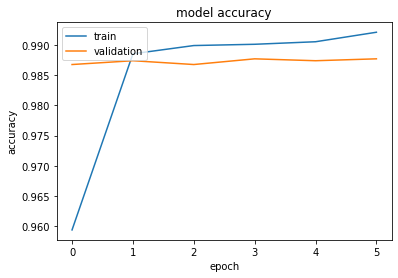

In [49]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Summarize history for loss

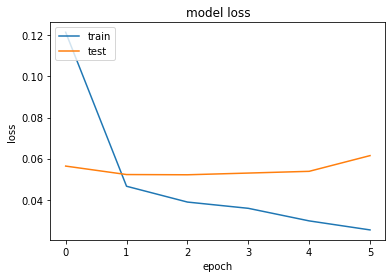

In [50]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Percentage accuracy of the model

In [51]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.77%


f1, precision, and recall scores

In [52]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1983
           1       1.00      0.97      0.98      1191

    accuracy                           0.99      3174
   macro avg       0.99      0.98      0.99      3174
weighted avg       0.99      0.99      0.99      3174



## Section 5: Comparing the Model to Base Line

In order to evaluate the effectiveness of the LSTM + CNN model, a logistic regression model is trained with the same train data and the same number of epochs, and tested with the same test data.

### Logistic Regression Base Line Model

In [47]:
class LogReg:
    """
    Class to represent a logistic regression model.
    """

    def __init__(self, l_rate, epochs, n_features):
        """
        Create a new model with certain parameters.

        :param l_rate: Initial learning rate for model.
        :param epoch: Number of epochs to train for.
        :param n_features: Number of features.
        """
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.

        :param score: A real valued number to convert into a number between 0 and 1
        """
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        """
        Given an example's features and the coefficients, predicts the class.

        :param features: List of real valued features for a single training example.

        :return: Returns the predicted class (either 0 or 1).
        """
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        """
        Computes the update to the weights based on a predicted example.

        :param features: Features to train on.
        :param label: Corresponding label for features.
        """
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        """
        Computes logistic regression coefficients using stochastic gradient descent.

        :param X: Features to train on.
        :param y: Corresponding label for each set of features.

        :return: Returns a list of model weight coefficients where coef[0] is the bias.
        """
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef 

In [48]:
def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy

Training the logistic regression model

In [53]:
# Logistic Model
logreg = LogReg(LEARNING_RATE, EPOCHS, len(data_train[0]))
bias_logreg, weights_logreg = logreg.train(data_train, labels_train)
y_logistic = [round(logreg.predict(example)) for example in data_test]

Getting the accuracy of the logistic regression model predicting the test data

In [54]:
# Compare accuracies
accuracy_logistic = get_accuracy(y_logistic, labels_test)
print('Logistic Regression Accuracy: {:0.3f}'.format(accuracy_logistic))

Logistic Regression Accuracy: 62.476
